In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Permute,AveragePooling2D,ELU
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.constraints import max_norm

In [ ]:
# For logging metrics to Weights and Biases Platform.
USING_WANDB = True  # Set to false if you don't have an account

if USING_WANDB:
    !pip install wandb &> /dev/null  # install wandb
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.login()  # prompts for api key

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Unzip data zip file
# !rm -r project_data
!unzip project_data.zip &> /dev/null
!rm -r __MACOSX
!mv project/* .
!rm -r project
# &> /dev/null  to quiet output

In [5]:
## Loading and visualizing the data

## Loading the dataset

X_test = np.load("X_test.npy")  # (443, 22, 1000)
y_test = np.load("y_test.npy")  # (443, 4)  # (num_trials, output types) # one hot encoded
person_train_valid = np.load("person_train_valid.npy")  # (2115, 1)  vals from 0-8 for participant
X_train_valid = np.load("X_train_valid.npy")  # (2115, 22, 1000)
# print(X_train_valid.shape)  # (2115, 22, 1000)  # (num_trials, channels, time bins)
y_train_valid = np.load("y_train_valid.npy")  # (2115,)
person_test = np.load("person_test.npy")  # (443, 1)

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


# plt.plot(np.arange(1000),avg_ch_data_class_0)
# plt.plot(np.arange(1000),avg_ch_data_class_1)
# plt.plot(np.arange(1000),avg_ch_data_class_2)
# plt.plot(np.arange(1000),avg_ch_data_class_3)
# plt.axvline(x=500, label='line at t=500',c='cyan')

# plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [6]:
def train_data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    # print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    # print('Shape of Y:',total_y.shape)
    return total_X,total_y


# Don't increase the number of test samples
def test_data_prep(X):
    total_X = None
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    # print('Shape of X after trimming:',X.shape)
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    total_X = X_max
    # print('Shape of X after maxpooling:',total_X.shape)
    return total_X

In [7]:
def preprocess(X_train_valid, y_train_valid, X_test, y_test, X_rest_test, y_rest_test):
    num_train_valid = X_train_valid.shape[0]
    print(num_train_valid, " total train_val samples")
    valid_split = 0.2
    valid_count = int(num_train_valid * valid_split)
    # Train val split, then data augment the training set
    ind_valid = np.random.choice(X_train_valid.shape[0], valid_count, replace=False)

    ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
    # Creating the training and validation sets using the generated indices
    (x_train_unprocessed, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
    (y_train_unprocessed, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

    # print("Augmenting train data")
    x_train, y_train = train_data_prep(x_train_unprocessed, y_train_unprocessed,2,2,True)
    # print("Augmenting val data")
    x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True)
    # print("Augmenting test data")
    X_test_prep = test_data_prep(X_test)
    X_rest_test_prep = test_data_prep(X_rest_test)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)
    y_rest_test = to_categorical(y_rest_test, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    x_rest_test = X_rest_test_prep[:, :, :, None]

    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    x_rest_test = np.swapaxes(x_rest_test, 1,3)
    x_rest_test = np.swapaxes(x_rest_test, 1,2)

    return x_train, y_train, x_valid, y_valid, x_test, y_test, x_rest_test, y_rest_test


In [8]:
def plot_acc_loss(model_results):
    plt.plot(model_results.history['accuracy'])
    plt.plot(model_results.history['val_accuracy'])
    plt.title('CNN model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plotting loss trajectory
    plt.plot(model_results.history['loss'],'o')
    plt.plot(model_results.history['val_loss'],'o')
    plt.title('CNN model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [9]:

def get_data(subject_idx):
    """Returns split and preprocessed data for both subject train and test (subject and rest)"""
    subject_mask = (person_train_valid == subject_idx).reshape(-1)
    x_sub_train_val = X_train_valid[subject_mask, :, :]
    y_sub_train_val = y_train_valid[subject_mask]
    # print(subject_mask.shape)
    # print(X_test.shape)
    subject_mask = (person_test == subject_idx).reshape(-1)
    x_sub_test = X_test[subject_mask, :, :]
    y_sub_test = y_test[subject_mask]

    X_rest_test = X_test[~subject_mask, :, :]  # data for all other subjects
    y_rest_test = y_test[~subject_mask]
    assert(X_test.shape[0] == x_sub_test.shape[0] + X_rest_test.shape[0])  # make sure nums add up

    return preprocess(x_sub_train_val, y_sub_train_val, x_sub_test, y_sub_test, X_rest_test, y_rest_test)
    # x_sub_train, y_sub_train, x_sub_valid, y_sub_valid, x_sub_test, y_sub_test, x_rest_test, y_rest_test
# len(get_data(0))

## Train a model using only one subject at a time and test on subject data and rest of subject data (repeat for each of subjects)


In [62]:
# SEED
tf.keras.utils.set_random_seed(0)

# TODO: try .5 dropout for one subject
num_channels = 22
num_classes = 4
input_shape = (400,1,num_channels)
num_units = 32  # 32
num_hidden = 512  #16
F1 = 8
D = 2
F2 = F1 * D
dropout_rate = 0.7  # .3  # .5 for within subject. .25 for across subject classification (larger dataset)
def create_model():
    model = Sequential([
        Permute((3, 1, 2), input_shape=input_shape),  # now in shape (channels, time, 1)
        # 2D conv across both
        # Temporal Conv2D
        Conv2D(F1, (1,64), padding="same"),  # , activation="relu"
        BatchNormalization(),
        # Depthwise Conv2D (spatial), across channels
        Conv2D(D * F1, (num_channels, 1), padding="valid", kernel_constraint=max_norm(1)),
        BatchNormalization(),
        ELU(),
        AveragePooling2D((1, 4)),  # pool down the time dim. average pool in the paper
        Dropout(dropout_rate),
        # Separable Conv2D  (across time)
        Conv2D(F2, (1,16), padding="same"),
        BatchNormalization(),
        ELU(),
        AveragePooling2D((1,8)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(num_classes, activation="softmax", kernel_constraint=max_norm(0.25))
    ])
    return model

In [63]:
# Try isolating each subject
USING_WANDB = False
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3
criterion="categorical_crossentropy"
checkpoint_filepath = 'ckpt/checkpoint.model.keras'
num_subjects = 9
sub_test_accs = []
rest_test_accs = []
for i in range(num_subjects):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience))
    callbacks.append(keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)
  )
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    print(f"Training on subject {i} (0-index)")
    x_sub_train, y_sub_train, x_sub_valid, y_sub_valid, x_sub_test, y_sub_test, x_rest_test, y_rest_test = get_data(i)

    model = create_model()

    model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

    # Training and validating the model
    model_results = model.fit(x_sub_train, y_sub_train,
                batch_size=batch_size,
                epochs=NUM_EPOCHS, callbacks=callbacks,
                validation_data=(x_sub_valid, y_sub_valid), verbose=0) # =1  #, verbose=True)

    print("Using best checkpoint for evaluation")
    loaded_model = keras.models.load_model(checkpoint_filepath)

    test_sub_acc = loaded_model.evaluate(x_sub_test, y_sub_test, verbose=0)[1]
    sub_test_accs.append(test_sub_acc)
    print(f'Test acc of the subject:      {test_sub_acc : .4f}')
    test_rest_acc = model.evaluate(x_rest_test, y_rest_test, verbose=0)[1]
    rest_test_accs.append(test_rest_acc)
    print(f'Test acc of rest of subjects: {test_rest_acc : .4f}')
    print()
    # plot_acc_loss(model_results)

Training on subject 0 (0-index)
237  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:       0.3600
Test acc of rest of subjects:  0.2621

Training on subject 1 (0-index)
236  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:       0.5200
Test acc of rest of subjects:  0.3333

Training on subject 2 (0-index)
236  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:       0.5200
Test acc of rest of subjects:  0.3257

Training on subject 3 (0-index)
234  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:       0.3400
Test acc of rest of subjects:  0.3206

Training on subject 4 (0-index)
235  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:       0.7447
Test acc of rest of subjects:  0.3485

Training on subject 5 (0-index)
236  total train_val samples
Using best checkpoint for evaluation
Test acc of the subject:   

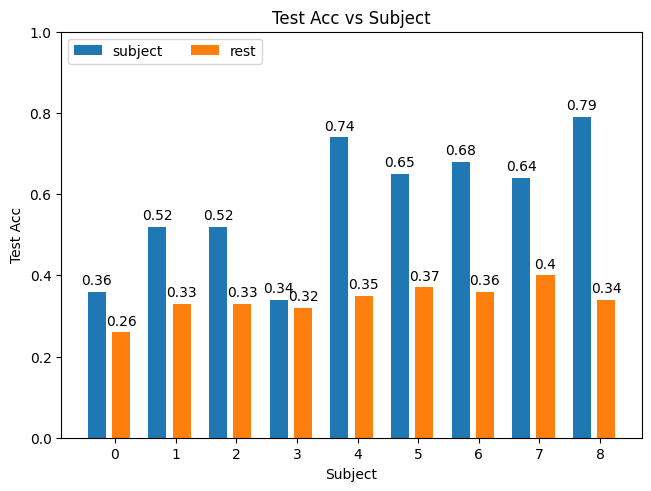

In [65]:
import matplotlib.pyplot as plt

x = np.arange(len(sub_test_accs))  # num_subjects # 9

width = 0.30  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for label, y in [('subject', sub_test_accs), ('rest', rest_test_accs)]:
    offset = width * multiplier
    y = np.round(y, 2)
    if label == 'rest':
      offset += 0.1
    rects = ax.bar(x + offset, y, width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Subject')
ax.set_ylabel('Test Acc')
ax.set_title('Test Acc vs Subject')
ax.set_xticks(x + width, np.arange(num_subjects))
ax.legend(loc='upper left', ncols=2)  # 3
ax.set_ylim(0, 1)  # y axis range from 0 to 1

plt.show()